# Imports and Loading the Network

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import silhouette_score

In [15]:
df = gpd.read_file('stations.geojson')
df['lon'] = df['geometry'].x
df['lat'] = df['geometry'].y
df['coords'] = [(lon, lat) for lon, lat in zip(df['geometry'].x, df['geometry'].y)]

df

,station_name,geometry,lon,lat,coords
0,Aadorf,POINT (8.90356 47.48793),8.903562,47.487933,"(8.90356210826161, 47.4879328611259)"
1,Aalen,POINT (10.09627 48.84102),10.096273,48.841016,"(10.0962732774588, 48.8410156251947)"
2,Aarau,POINT (8.05418 47.39186),8.054178,47.391855,"(8.05417805754984, 47.3918550928188)"
3,Aarau Torfeld,POINT (8.06264 47.39356),8.062640,47.393564,"(8.06264018752743, 47.3935639441972)"
4,Aarberg,POINT (7.27807 47.04368),7.278070,47.043676,"(7.27806958457391, 47.043675861814)"
...,...,...,...,...,...
3468,Öhningen (See),POINT (8.89457 47.65210),8.894570,47.652096,"(8.89456997226632, 47.6520963732232)"
3469,Überlingen,POINT (9.16285 47.76910),9.162852,47.769101,"(9.16285183190596, 47.7691005639212)"
3470,Überlingen Hafen,POINT (9.16076 47.76581),9.160759,47.765810,"(9.16075875729367, 47.7658098824035)"
3471,Überlingen Therme,POINT (9.14564 47.76927),9.145640,47.769270,"(9.14564011105984, 47.7692696208351)"


The graph is loaded from the `sbb.edgelist`.
Make sure to create this edgelist through the `create_edgelist.py` script.

In [24]:
G = nx.read_edgelist("sbb.edgelist", delimiter=";", create_using=nx.Graph)
for idx, row in df.iterrows():
    station_name = row['station_name']
    lon = row['lon']
    lat = row['lat']
    # Check if the station name exists in the graph
    if station_name in G.nodes:
        # Set latitude and longitude attributes
        G.nodes[station_name]['lon'] = lon
        G.nodes[station_name]['lat'] = lat
        G.nodes[station_name]['coords'] = (lon, lat)

print(G.nodes['Aadorf'])

{'lon': 8.90356210826161, 'lat': 47.4879328611259, 'coords': (8.90356210826161, 47.4879328611259)}


In [22]:
# KARATE CLUB TEST
# G = nx.karate_club_graph()

# LES MISERABLES TEST
# G = nx.les_miserables_graph()

In [25]:
print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

number of nodes: 3473
number of edges: 8610


# 2. Community Detection

## Louvain

In [6]:
louvain = nx.community.louvain_communities(G, seed=42, resolution=1)

louvain_len = [len(s) for s in louvain]
print("Louvain: number of communities:", len(louvain))
print("Louvain: size of each community:", louvain_len)

Louvain: number of communities: 4
Louvain: size of each community: [6, 10, 4, 14]


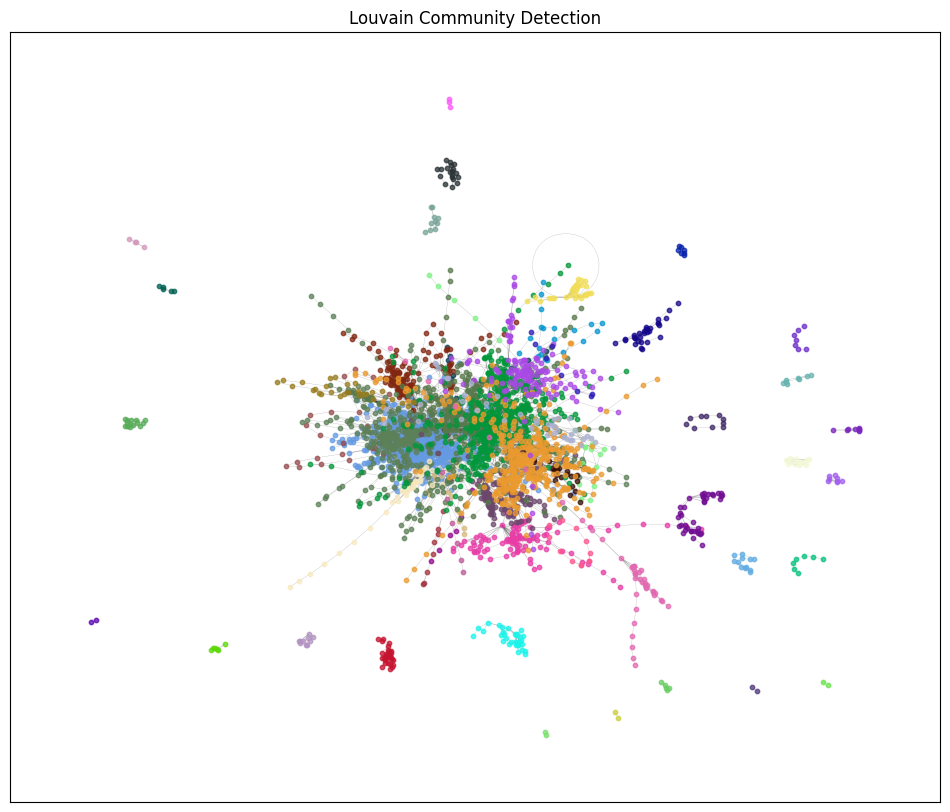

In [5]:
getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

colors = getcolors(len(louvain))

plt.figure(figsize=(12, 10))    
pos = nx.spring_layout(G, seed=42)     
for i, c in enumerate(louvain):   
    nx.draw_networkx_nodes(     
        G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
    )            

nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
plt.title("Louvain Community Detection")
plt.show()

# TODO: use edge weights to help visualise the graph

## Louvain with Largest Connected Components

In [6]:
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

sub_G = G.subgraph(max_connected_comp)
louvain = nx.community.louvain_communities(sub_G, seed=42, resolution=0.5)

louvain_len = [len(s) for s in louvain]
print("Louvain LCC: number of communities:", len(louvain))
print("Louvain LCC: size of each community:", louvain_len)             

Number of nodes in largest connected component: 3017
Louvain LCC: number of communities: 16
Louvain LCC: size of each community: [214, 315, 13, 527, 439, 148, 108, 139, 32, 133, 7, 329, 22, 530, 28, 33]


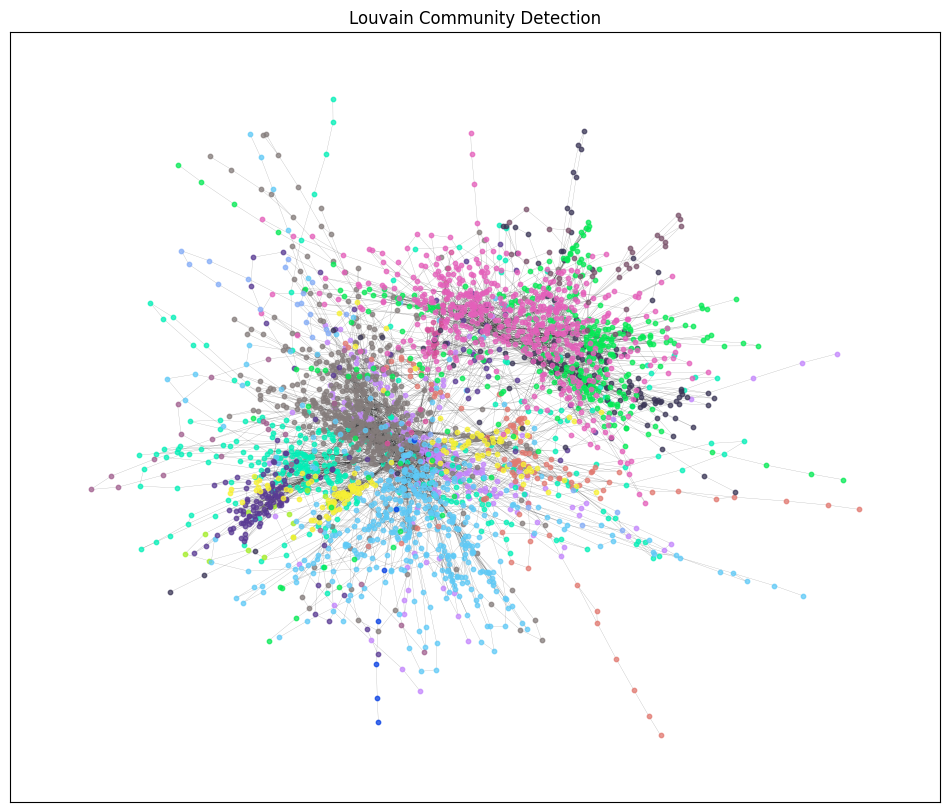

In [7]:
getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

colors = getcolors(len(louvain))

plt.figure(figsize=(12, 10))    
pos = nx.spring_layout(sub_G, seed=42)     
for i, c in enumerate(louvain):   
    nx.draw_networkx_nodes(     
        sub_G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
    )            

nx.draw_networkx_edges(sub_G, pos=pos, width=0.20, alpha=0.33)
plt.title("Louvain Community Detection")
plt.show()

## Louvain Iteration Times
- should we run it multiple times?

In [12]:
# TODO: silhouette score
def silhouette(G, found_communities, verbose=False):
    # make a dictionary with node as key and final community as value
    node_to_community = {node: comm_idx for comm_idx, community in enumerate(found_communities) for node in community}
    # list all final communities by indexing with keys
    comm_labels = [node_to_community[node] for node in G.nodes()]
    # # turn graph into numpy adjacency matrix
    matrix = nx.to_numpy_array(G)
    # calc silhouette score by inputting graph as an array and the communities as labels
    sil_score = silhouette_score(nx.to_numpy_array(G), comm_labels, metric='euclidean', random_state=42)
    if verbose:
        print("Silhouette Score:", s_score)
    return sil_score

In [26]:
all_times = []
silhouette_scores = []
modularity_scores = []
for _ in range(10):
    louvain_partitions = nx.community.louvain_partitions(G)
    i_times = []
    i_silhouette = []
    i_modularity = []
    while True:
        start_time = time.time()
        communities = next(louvain_partitions, 'finished')
        stop_time = time.time()
        i_time = stop_time - start_time
        if communities == 'finished':
            break 
        i_times.append(i_time)
        s_score = silhouette(G, communities)
        i_silhouette.append(s_score)
        m_score = nx.community.modularity(G, communities)
        i_modularity.append(m_score)
        final_communities = communities

    all_times.append(i_times)
    silhouette_scores.append(i_silhouette)
    modularity_scores.append(i_modularity)
    
    
print(f'iteration times: {all_times}')
print(f'silhouette scores per iteration: {silhouette_scores}')
print(f'modularity scores per iteration: {modularity_scores}')
print(f'final number of communities: {len(final_communities)}')

with open("nx_louvain_iteration_times.txt", 'w') as output:
    for row in all_times:
        output.write(str(row) + '\n')
        
with open("nx_louvain_silhouette_scores_per_iteration.txt", 'w') as output:
    for row in silhouette_scores:
        output.write(str(row) + '\n')
        
with open("nx_louvain_modularity_scores_per_iteration.txt", 'w') as output:
    for row in modularity_scores:
        output.write(str(row) + '\n')

iteration times: [[0.9276683330535889, 0.09076738357543945, 0.016463279724121094, 0.004491567611694336], [0.41335225105285645, 0.07523107528686523, 0.02503180503845215, 0.0042188167572021484], [0.35497474670410156, 0.09852766990661621, 0.02728867530822754, 0.005431413650512695], [0.30561327934265137, 0.08782601356506348, 0.015607118606567383, 0.006766796112060547], [0.3902313709259033, 0.12787866592407227, 0.02178025245666504, 0.00455021858215332], [0.4640688896179199, 0.06449341773986816, 0.21975207328796387, 0.0034575462341308594], [0.30647850036621094, 0.07649636268615723, 0.014072895050048828, 0.0032660961151123047], [0.38481783866882324, 0.12035298347473145, 0.016009807586669922, 0.0035216808319091797], [0.3368260860443115, 0.06760334968566895, 0.01595473289489746, 0.0043337345123291016], [0.421006441116333, 0.0863034725189209, 0.01564478874206543, 0.0042455196380615234]]
silhouette scores per iteration: [[-0.12970758004724545, -0.17870035373175336, -0.20955931474095557, -0.210678

In [10]:
# def silhouette_score(communities, v):
#     for cluster in communities:
#         for x in cluster:
#             cluster.remove(x)
#             for y in cluster:
#                 a_term_1 = 1/len(cluster) 
#                 a_term_2 = sum(abs(x-y)**2)
#                 a = a_term_1 - a_term_2

4


## Girvan-Newman

In [ ]:
all_times = []
silhouette_scores = []
timeout = time.time() + 60 * 60 * 7 # run for 7 hours

gn_partitions = nx.community.girvan_newman(G)
i_times = []
i_silhouette = []

while True:
    if time.time() > timeout:
        break
    start_time = time.time()
    communities = next(gn_partitions, 'finished')
    stop_time = time.time()
    i_time = stop_time - start_time
    if communities == 'finished':
        break 
    i_times.append(i_time)
    s_score = silhouette(communities, G)
    i_silhouette.append(s_score)
    final_communities = communities

all_times.append(i_times)
silhouette_scores.append(i_silhouette)
    
print(f'iteration times: {all_times}')
print(f'silhouette scores per iteration: {silhouette_scores}')
print(len(final_communities))

with open("nx_gn_iteration_times.txt", 'w') as output:
    for row in all_times:
        output.write(str(row) + '\n')
        
with open("nx_gn_silhouette_scores_per_iteration.txt", 'w') as output:
    for row in silhouette_scores:
        output.write(str(row) + '\n')

In [69]:
%%time
import time

gn_communities = nx.community.girvan_newman(G)

it = 0
i = []

# Apply Girvan-Newman iteratively for > 1 hour
timeout = time.time() + 60 * 1
while True:
    if time.time() > timeout:
        break
    it += 1
    i = next(gn_communities, 'end')

print(f'number of iterations: {it}')

KeyboardInterrupt: 

Size of community 1: 971
Size of community 2: 488
Size of community 3: 144
Size of community 4: 254
Size of community 5: 1070
Size of community 6: 62
Size of community 7: 28


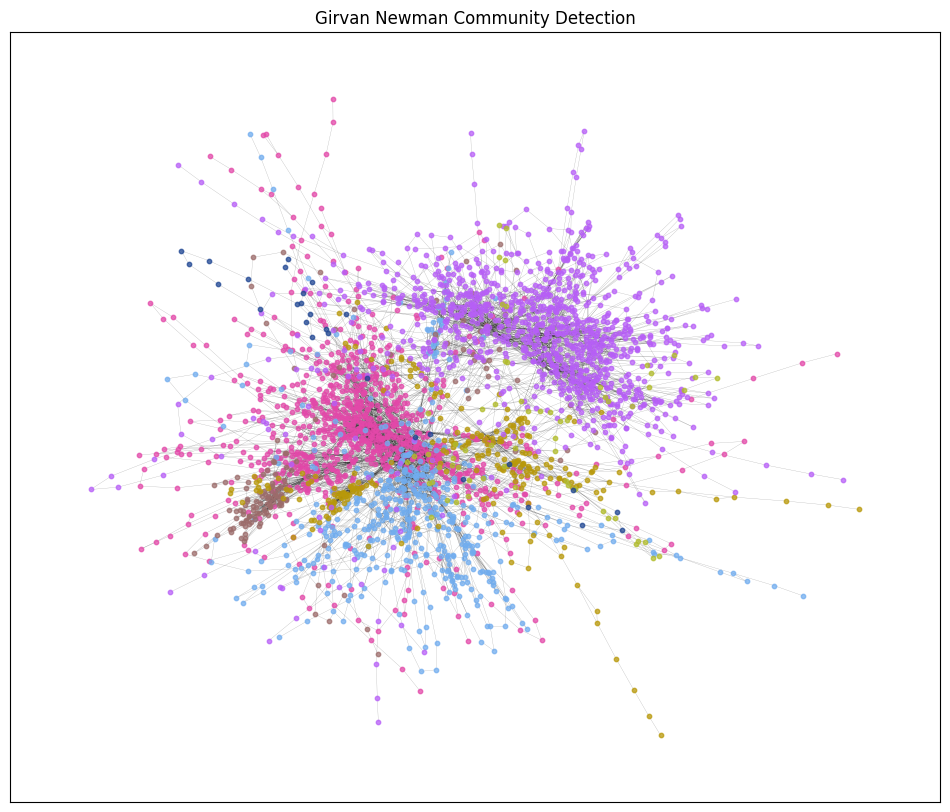

In [9]:
# Report the size of each community and draw the graph. Color the nodes according to their community.

getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colors = getcolors(len(i))

plt.figure(figsize=(12, 10))    
pos = nx.spring_layout(sub_G, seed=42)     
for idx, c in enumerate(i):
    print(f'Size of community {idx+1}: {len(c)}')
    nx.draw_networkx_nodes(     
        sub_G, pos=pos, nodelist=c, node_color=colors[idx], node_size=10, alpha=0.75        
    )            

nx.draw_networkx_edges(sub_G, pos=pos, width=0.20, alpha=0.33)
plt.title("Girvan Newman Community Detection")
plt.show()